1. Считать данные из источника https://disk.yandex.ru/d/s6wWqd8Ol_5IvQ
2. Внести данные из таблицы в графовую БД
3. Построить графовое представление в БД, осуществить несколько запросов на языке запросов к графовой БД
4. Важный пункт. Найти взаимосвязи визуально и с помощью алгоритмов (алгоритмы на ваше усмотрение). Обратить внимание на сложные сообщества, провести анализ сложных сообществ, сделать выводы.
5. Написать rest сервис на python к графовой БД в котором на вход поступает ФИО, на выходе graphml или json

# Считать данные из источника

Для загрузки данных необходимо именно скачать файл, так как ссылка имеет лимит скачиваний. 
Данные из файла идут с разделителем ";" и далее их просмотр. 
Импортированы модули:

In [381]:
import numpy as np
import pandas as pd
import json

In [379]:
df=pd.read_csv("D:/DS/data_test.csv", sep = ';')
df

,id события,ФИО участника события 1,ФИО участника события 2
0,189,Галчевская Карина Владимировна,Белоновская Анастасия Семеновна
1,206,Офицеров Олег Романович,Сапожник Борис Валерьевич
2,445,Жандарова Лариса Германовна,Чемодуров Дамир Русланович
3,503,Масимова Яна Дамировна,Мингажетдинов Рамиль Семенович
4,571,Мухтарова Алена Яковлевна,Щербатенко Ольга Робертовна
...,...,...,...
4995,999333,Осташов Владимир Данилович,Чалов Илья Владимирович
4996,999360,Гандыбина Любовь Александровна,Мерлин Илья Юрьевич
4997,999403,Востоков Виктор Ильдарович,Аликас Никита Андреевич
4998,999405,Огарева Людмила Ильдаровна,Нагайцева Алина Степановна


Смена названий колонок без потери смысла для удобства дальнейшей работы:

In [399]:
df.columns = ['event_id', 'person_1', 'person_2']
df

,event_id,person_1,person_2
0,189,Галчевская Карина Владимировна,Белоновская Анастасия Семеновна
1,206,Офицеров Олег Романович,Сапожник Борис Валерьевич
2,445,Жандарова Лариса Германовна,Чемодуров Дамир Русланович
3,503,Масимова Яна Дамировна,Мингажетдинов Рамиль Семенович
4,571,Мухтарова Алена Яковлевна,Щербатенко Ольга Робертовна
...,...,...,...
4995,999333,Осташов Владимир Данилович,Чалов Илья Владимирович
4996,999360,Гандыбина Любовь Александровна,Мерлин Илья Юрьевич
4997,999403,Востоков Виктор Ильдарович,Аликас Никита Андреевич
4998,999405,Огарева Людмила Ильдаровна,Нагайцева Алина Степановна


Подсчет числа одинаковых элементов в колонках персон:

In [344]:
copy = 0
for prob_copy_1 in df.person_1:
    for prob_copy_2 in df.person_2:
        if prob_copy_1==prob_copy_2:
            copy = copy+1
print(copy)

85


Выяснилось, что один и тот же человек может присутствовать с обеих колонках несколько раз. 
Глядя на данные, сразу хочется посмотреть, может ли один человек учавствовать в нескольких событиях и может ли конкретное событие проиходить с более чем двумя людьми. Если это так, тогда значения в колонках будут повторятся.
При этом не будет пустых значений в отдельных ячейках.

In [382]:
print ([df.nunique().sum(), df.nunique(), df.isnull().count()])

[14909, id события                 4985
ФИО участника события 1    4930
ФИО участника события 2    4994
dtype: int64, id события                 5000
ФИО участника события 1    5000
ФИО участника события 2    5000
dtype: int64]


# Внести данные из таблицы в графовую БД

Для реализации графового построения необходимо подготовить датафрейм к импорту в среду neo4j:
 - Установить neo4j;
 - Заменить кириллическое представление сущностей в датафрейме на латиницу для корректного отображения графа

In [400]:
import unidecode

In [401]:
for i in range(len(df)):
    df.loc[i, 'person_1'] = unidecode.unidecode(df['person_1'][i])
    df.loc[i, 'person_2'] = unidecode.unidecode(df['person_2'][i])
df

,event_id,person_1,person_2
0,189,Galchevskaia Karina Vladimirovna,Belonovskaia Anastasiia Semenovna
1,206,Ofitserov Oleg Romanovich,Sapozhnik Boris Valer'evich
2,445,Zhandarova Larisa Germanovna,Chemodurov Damir Ruslanovich
3,503,Masimova Iana Damirovna,Mingazhetdinov Ramil' Semenovich
4,571,Mukhtarova Alena Iakovlevna,Shcherbatenko Ol'ga Robertovna
...,...,...,...
4995,999333,Ostashov Vladimir Danilovich,Chalov Il'ia Vladimirovich
4996,999360,Gandybina Liubov' Aleksandrovna,Merlin Il'ia Iur'evich
4997,999403,Vostokov Viktor Il'darovich,Alikas Nikita Andreevich
4998,999405,Ogareva Liudmila Il'darovna,Nagaitseva Alina Stepanovna


Датафрейм был сохранен в новый файл *.csv:

In [383]:
df.to_csv('dataset_test.csv', index=False)

Для импорта датафрейма в neo4j необходимо импортировать модули GraphDatabase, basic_auth из neo4j. 
Для построения визуального представления импортирован GraphWidget.

In [384]:
#pip install yfiles_jupyter_graphs
from neo4j import GraphDatabase, basic_auth
from yfiles_jupyter_graphs import GraphWidget

# Построить графовое представление, сделать несколько запросов, провести анализ сообществ

Предварительно в среде Neo4j Desktop была создана пустая база данных. 
Создан драйвер для подключения в среде jupiter

In [345]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "12345678"))

Непосредтственно импорт в базу происходит по запросу на языке Cypher. 
В этом запросе создаются вершины и связи между вершинами на основе датафрейма. Вершинами являются события и персоны. 
Если вершина с таким же 'Name' была создана ранее, то новая не создается. 

In [346]:
query_import = '''
LOAD CSV FROM 'file:///dataset_test.csv' as line
FIELDTERMINATOR ','
     MERGE (n:event{Name: line[0]})
     MERGE (m:person{Name: line[1]})
     MERGE (s:person{Name: line[2]})
     MERGE (m)-[:R]->(n) 
     MERGE (s)-[:R]->(n)
'''              

В этой сессии реализуется запрос 'query_import'.

In [347]:
session = driver.session()
session.run(query_import)

Проверка количества уникальных вершин, загруженных в базу. 

In [348]:
query_check = '''
MATCH (n) 
RETURN count(n)
'''
answer = session.run(query_check)
print (answer.single()['count(n)'])

14884


Предварительный эвристический анализ датафрейма предполагает наличие сообществ. Необходимо найти эти сообщества. 
Составляется запрос, который "выкидывает" из результата persons и events, которые одновременно удовлетворяют 
следующему условию: person имеет только одно отношение и event который имеет только два отношения. 
Этот запрос выведет вершины и отношения, задействованные в сообществах. Предварительно они помечены как INTER. 
Остальное не представляет интереса для анализа. 

In [349]:
query_label_event = '''
MATCH (n)-[b]-(e:event)
WITH e, count(b) AS con
WHERE con > 2
SET e:INTER
'''
session.run(query_label_event)

query_label_node = '''
MATCH (n)-[b]-(e:event)
WITH n, count(b) AS con
WHERE con > 1
SET n:INTER
'''
session.run(query_label_node)

query_out_INTER = '''
MATCH  (m)-[a]-(e:event)-[b*]-(x)
WHERE m:INTER OR e:INTER
RETURN (m), (e), (x), (a), (b)
'''

graph = session.run(query_out_INTER).graph()
w = GraphWidget(graph = graph)

Словарь с визуальными свойствами графа

In [350]:
styles = {
    'event':{'color': '#6C7400', 'shape': 'ellipse', 'label':'Name'},
    'person':{'color': '#005977', 'shape': 'octagon', 'label':'Name'}
}

"Наделение" свойствами визуализиемого графа

In [351]:
w.set_node_styles_mapping(lambda index, node: styles.get(node['properties']['label'], {}))
w.set_node_label_mapping(lambda index, node: node['properties']['Name'])

In [352]:
len(w.nodes)

280

In [353]:
len(w.edges)

264

In [354]:
w.show()

GraphWidget(layout=Layout(height='500px', width='100%'))

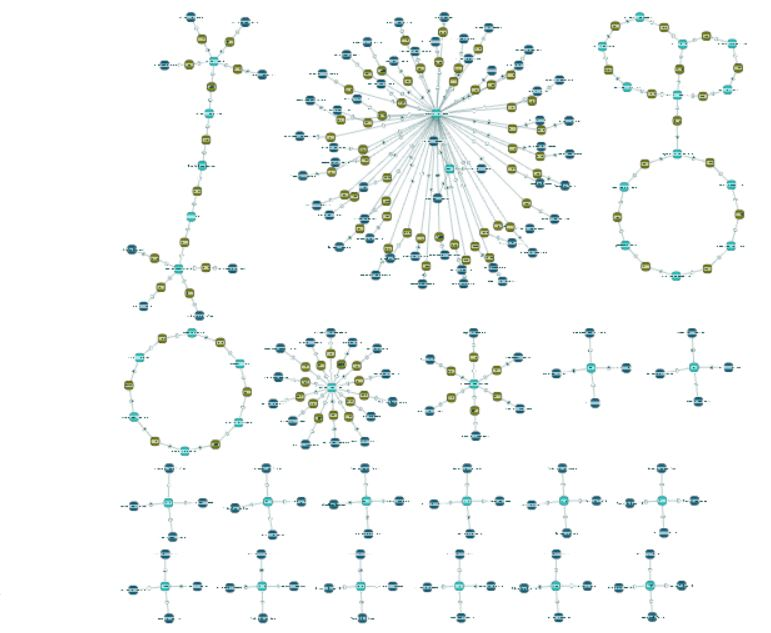

Визуально было обнаружено 20 сообществ. Под сообществом понимается связанная структура из более чем одного события или более чем двух персон. В некоторых сообществах есть персоны - лидеры, однако большинство сообществ небольшие и центральным объектом таких небольших сообществ является событие. На следующем этапе анализа из графового представления выделены только минимальные сообщества. Алгоритм их выделения показан в запросе query_min_social

Выглядят маленькие сообщества одинаково. Визуальный пример одного такого маленького сообщества.

In [355]:
query_min_social_example = '''
MATCH  (e:event {Name: '70049'})<-[m]-(x)
RETURN  e, x, m 
'''
session = driver.session()
graph = session.run(query_min_social_example).graph()
xmp = GraphWidget(graph = graph)
xmp.set_node_label_mapping(lambda index, node: node['properties']['Name'])
xmp.show()

GraphWidget(layout=Layout(height='500px', width='100%'))

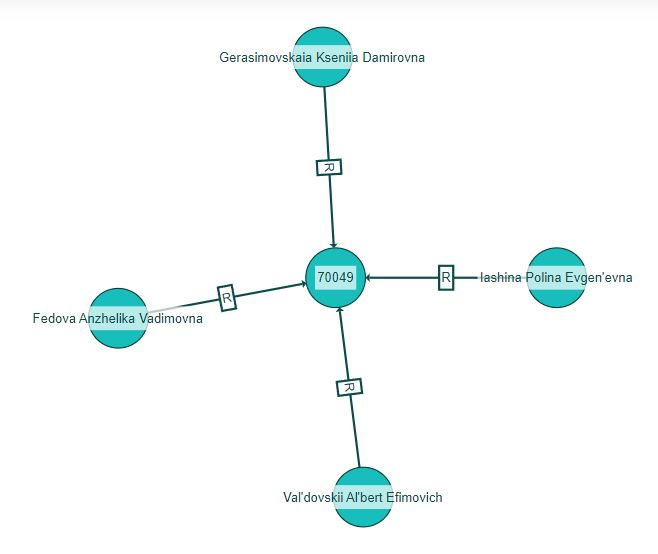

Вывод списка с номером минимального сообщества и его участниками. 
Номер сообщества - это номер события, "вокруг" которого собрались участники.
Это маленькие сообщества без лидера. Стоит отметить, что сообщество 'Name': '850472'
попало с список минимальных, но также оно является частью большого сообщества. 

In [356]:
query_min_social = '''
MATCH  (e:INTER)<-[*]-(x)
WITH e.Name AS Name, collect (x) AS prt
RETURN  Name, prt 
'''
session = driver.session()
min_social = session.run(query_min_social) 
min_social.data()

[{'Name': '70049',
  'prt': [{'Name': 'Fedova Anzhelika Vadimovna'},
   {'Name': "Iashina Polina Evgen'evna"},
   {'Name': "Val'dovskii Al'bert Efimovich"},
   {'Name': 'Gerasimovskaia Kseniia Damirovna'}]},
 {'Name': '92995',
  'prt': [{'Name': "Kucherenko Irina Il'inichna"},
   {'Name': "Bad'ianova Rimma Maksimovna"},
   {'Name': 'Boltik Grigorii Maksimovich'},
   {'Name': "Zhurik Al'bert Evgen'evich"}]},
 {'Name': '117280',
  'prt': [{'Name': "Utochkin Evgenii Anatol'evich"},
   {'Name': 'Kaganovich Liliia Petrovna'},
   {'Name': 'Gaisumov Viktor Timurovich'},
   {'Name': 'Volynskii Kirill Fedorovich'}]},
 {'Name': '177407',
  'prt': [{'Name': 'Zelinskii Gennadii Arturovich'},
   {'Name': 'Buzhaninov Ruslan Arturovich'},
   {'Name': 'Sorokovoi German Maratovich'},
   {'Name': "Zazorin Vadim Arkad'evich"}]},
 {'Name': '358194',
  'prt': [{'Name': 'Serpukhova Alla Iaroslavovna'},
   {'Name': "Brusentsova Dar'ia Mikhailovna"},
   {'Name': 'Dolgikh Liliia Vadimovna'},
   {'Name': 'Noeva

Далее необходимо рассмотреть большие сложные сообщества 

In [357]:
"""Визуализация только сложных сообществ"""
query_max_social_graph = '''
MATCH  (m:INTER)-[b*]-(e:event)-[a*]-(x:person)
RETURN *
'''
graph = session.run(query_max_social_graph).graph()
s_max = GraphWidget(graph = graph)
s_max.set_node_styles_mapping(lambda index, node: styles.get(node['properties']['label'], {}))
s_max.set_node_label_mapping(lambda index, node: node['properties']['Name'])
s_max.show()

GraphWidget(layout=Layout(height='500px', width='100%'))

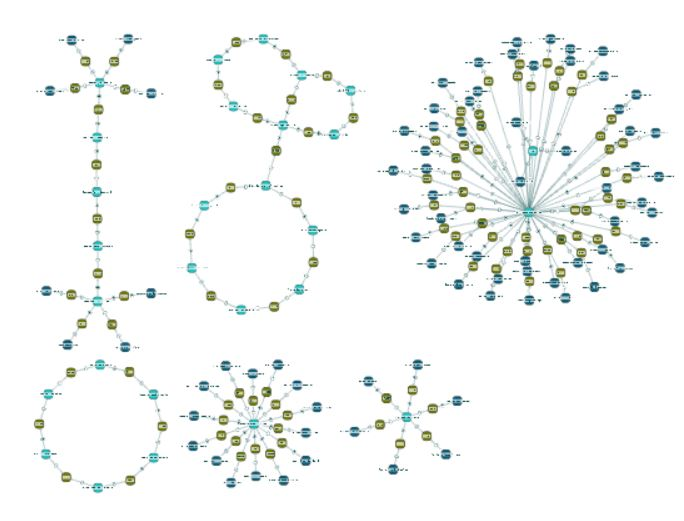

Визуально можно выделить 6 сложных сообществ. Их перечень представлен ниже.
Внутри этих сообществ следует выделить лидера. Под лидерами понимаются персоны, 
обладающие более чем одной связью с событиями и другими персонами.  
Далее рассмотрено каждое сообщество отдельно. В сложных сообществах может не быть явного лидера и для полноценного
анализа стоит учитывать контекст данных, чтобы определить заранее перечень ролей для отдельных персон. 

Список ключевых участников каждого из шести сообществ. Эти персоны были помечены как имеющие более одной связи.
Далее каждое из сложных сообществ будет проанализировано отдельно и для его построения будет применено имя 
персоны из списка. 

In [358]:
query_list_lead = '''
MATCH  (m:INTER)-[a]->(e:event)-[*]-(x)
RETURN DISTINCT (m) AS lead
'''
leads = session.run(query_list_lead).data()
lead_list = []
for i in leads: 
    Name_lead = i.values()
    Name_lead = list(Name_lead)[0].values()
    lead_list.append(list(Name_lead))
lead_list

[['Akhromeeva Alina Ivanovna'],
 ['Bashnina Antonina Glebovna'],
 ['Pafomova Kira Vadimovna'],
 ['Zimnukhova Karina Danilovna'],
 ["Medvedeva Dar'ia Alekseevna"],
 ['Nedoveskov Vladimir Ivanovich'],
 ["Sholokhov Igor' Robertovich"],
 ['Danilenko Vladimir Semenovich'],
 ["Mailina Gul'nara Ivanovna"],
 ['Anikhnova Tamara Ruslanovna'],
 ["Dvigubskaia Valentina Gennad'evna"],
 ["Diomidov Igor' Il'darovich"],
 ['Ivashev Viacheslav Igorevich'],
 ['Nagaitseva Anzhelika Ianovna'],
 ['Radionova Tamara Iaroslavovna'],
 ['Batievskaia Angelina Romanovna'],
 ["Iatskoi Robert Il'darovich"],
 ['Troekurov Gleb Efimovich'],
 ["Kaekhtin Il'dar Eduardovich"],
 ['Torgunakov Roman Kirillovich'],
 ['Dorozhkin Anatolii Egorovich'],
 ['Podolian Vladislav Denisovich'],
 ['Poskrebyshev Iakov Dmitrievich'],
 ["Ryskina El'mira Ivanovna"],
 ['Liaudanskii Valentin Vladislavovich'],
 ["Marakhovskaia Dar'ia Romanovna"],
 ['Bugaichuk Roman Eduardovich']]

Визуализация и состав первого сообщества: 

In [359]:
query_social_1 = '''
MATCH  (m:INTER {Name:'Akhromeeva Alina Ivanovna'})-[b]->(e:event)-[a*]-(x) 
RETURN *
'''
session = driver.session()
graph = session.run(query_social_1).graph()
s1 = GraphWidget(graph = graph)
s1.set_node_styles_mapping(lambda index, node: styles.get(node['properties']['label'], {}))
s1.set_node_label_mapping(lambda index, node: node['properties']['Name'])
s1.show()

GraphWidget(layout=Layout(height='500px', width='100%'))

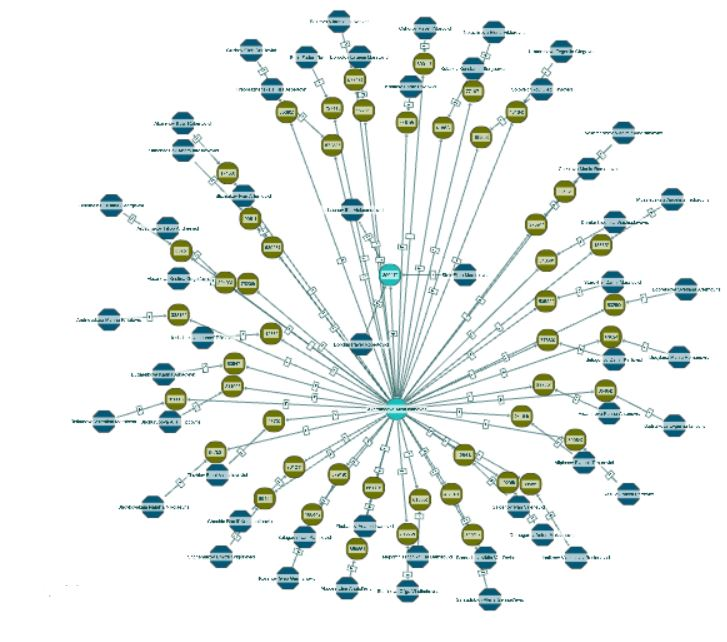

In [361]:
query_social_1_list = '''MATCH (m:INTER{Name:'Akhromeeva Alina Ivanovna'})-[*]-(e:event)-[a*]-(x)
WITH m AS lead, count(x) AS degree, collect(x) AS partiсipant
RETURN lead, degree, partiсipant'''

participant_1= session.run(query_social_1_list).data()
participant_1

[{'lead': {'Name': 'Akhromeeva Alina Ivanovna'},
  'degree': 52,
  'partiсipant': [{'Name': "Nepomniashchikh Il'ia Damirovich"},
   {'Name': 'Netuzhilova Elena Viktorovna'},
   {'Name': 'Borgolov Evgenii Maratovich'},
   {'Name': 'Shchurupova Alla Filippovna'},
   {'Name': 'Chikireva Mariia Romanovna'},
   {'Name': "Bugaenkova Karina Arkad'evna"},
   {'Name': "Abarenov Il'dar Robertovich"},
   {'Name': 'Solomeina Kristina Georgievna'},
   {'Name': 'Salagaev Ivan Ramilevich'},
   {'Name': 'Bekreva Viktoriia Iakovlevna'},
   {'Name': 'Kamilov Damir Pavlovich'},
   {'Name': "Bordachev Nikita Vasil'evich"},
   {'Name': "Sarsadskikh Alena Gennad'evna"},
   {'Name': "Akodes Efim Anatol'evich"},
   {'Name': "Chechin Ramil' Konstantinovich"},
   {'Name': "Shovkovskaia Natal'ia Nikolaevna"},
   {'Name': "Shchennikov Dmitrii Grigor'evich"},
   {'Name': 'Soloveichikov Oleg Pavlovich'},
   {'Name': 'Kamchadalov Artem Iaroslavovich'},
   {'Name': 'Urmantseva Evgeniia Olegovna'},
   {'Name': 'Aidami

In [362]:
query_social_2 = '''
MATCH  (m:INTER {Name:'Bashnina Antonina Glebovna'})-[b]->(e:event)-[a*]-(x) 
RETURN *
'''
session = driver.session()
graph = session.run(query_social_2).graph()
s2 = GraphWidget(graph = graph)
s2.set_node_label_mapping(lambda index, node: node['properties']['Name'])
s2.set_node_styles_mapping(lambda index, node: styles.get(node['properties']['label'], {}))
s2.show()

GraphWidget(layout=Layout(height='500px', width='100%'))

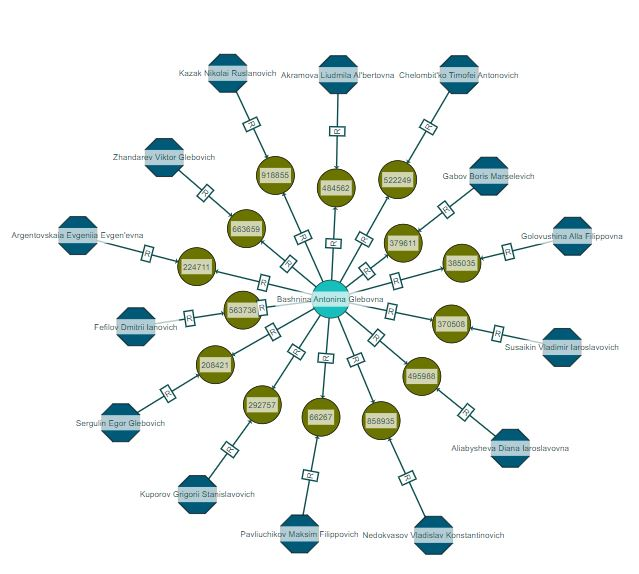

In [364]:
query_social_2_list = '''MATCH (m:INTER{Name:'Bashnina Antonina Glebovna'})-[*]-(e:event)-[a*]-(x)
WITH m AS lead, count(x) AS degree, collect(x) AS partiсipant
RETURN lead, degree, partiсipant'''

participant_2= session.run(query_social_2_list).data()
participant_2

[{'lead': {'Name': 'Bashnina Antonina Glebovna'},
  'degree': 14,
  'partiсipant': [{'Name': 'Sergulin Egor Glebovich'},
   {'Name': "Akramova Liudmila Al'bertovna"},
   {'Name': 'Zhandarev Viktor Glebovich'},
   {'Name': 'Kuporov Grigorii Stanislavovich'},
   {'Name': "Argentovskaia Evgeniia Evgen'evna"},
   {'Name': "Chelombit'ko Timofei Antonovich"},
   {'Name': 'Susaikin Vladimir Iaroslavovich'},
   {'Name': 'Nedokvasov Vladislav Konstantinovich'},
   {'Name': 'Golovushina Alla Filippovna'},
   {'Name': 'Pavliuchikov Maksim Filippovich'},
   {'Name': 'Gabov Boris Marselevich'},
   {'Name': 'Fefilov Dmitrii Ianovich'},
   {'Name': 'Aliabysheva Diana Iaroslavovna'},
   {'Name': 'Kazak Nikolai Ruslanovich'}]}]

In [365]:
query_social_3 = '''
MATCH  (m:INTER {Name:'Bugaichuk Roman Eduardovich'})-[b]-(e:event)-[a*]-(x) 
RETURN *
'''
session = driver.session()
graph = session.run(query_social_3).graph()
s3 = GraphWidget(graph = graph)
s3.set_node_styles_mapping(lambda index, node: styles.get(node['properties']['label'], {}))
s3.set_node_label_mapping(lambda index, node: node['properties']['Name'])
s3.show()

GraphWidget(layout=Layout(height='500px', width='100%'))

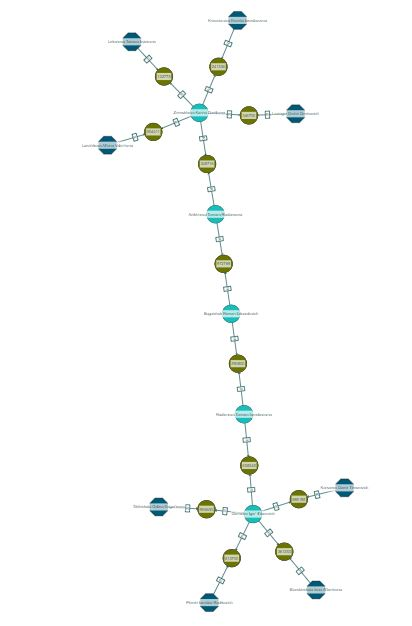

Это сообщество интересное. Явного лидера не представляется возможным выделить, однако запрос для построения выполнен
относительно централной персоны. Относительно нее будут высчитаны степени связности. Возможно также ввести понятие "веса" персоны. Введена колонка степени связности step для членов такого сообщества.

In [366]:
query_social_3_list = '''
MATCH p = (m:INTER{Name: 'Bugaichuk Roman Eduardovich'})-[z*]-(x:person) 
RETURN  m AS start_member, collect(x) AS participant, length(p)/2 AS step
'''
participant_3 = session.run(query_social_3_list).data()
participant_3

[{'start_member': {'Name': 'Bugaichuk Roman Eduardovich'},
  'participant': [{'Name': 'Radionova Tamara Iaroslavovna'},
   {'Name': 'Anikhnova Tamara Ruslanovna'}],
  'step': 1},
 {'start_member': {'Name': 'Bugaichuk Roman Eduardovich'},
  'participant': [{'Name': "Diomidov Igor' Il'darovich"},
   {'Name': 'Zimnukhova Karina Danilovna'}],
  'step': 2},
 {'start_member': {'Name': 'Bugaichuk Roman Eduardovich'},
  'participant': [{'Name': 'Pitenin Iaroslav Radikovich'},
   {'Name': 'Karsanov Damir Timurovich'},
   {'Name': "Tiktinskaia Galina Grigor'evna"},
   {'Name': "Starobinskaia Iana Al'bertovna"},
   {'Name': 'Loviagin Dmitrii Denisovich'},
   {'Name': "Lanchikova Al'bina Valer'evna"},
   {'Name': 'Lekanova Tamara Ivanovna'},
   {'Name': 'Krivoviazova Kseniia Iaroslavovna'}],
  'step': 3}]

Такое представление в совокупности с визуальным дает информацию о структуре и составе сообщества

In [367]:
query_social_4 = '''
MATCH  (m:INTER {Name:"Medvedeva Dar'ia Alekseevna"})-[b]->(e:event)-[a*]-(x) 
RETURN *
'''
session = driver.session()
graph = session.run(query_social_4).graph()
s4 = GraphWidget(graph = graph)
s4.set_node_styles_mapping(lambda index, node: styles.get(node['properties']['label'], {}))
s4.set_node_label_mapping(lambda index, node: node['properties']['Name'])
s4.show()

GraphWidget(layout=Layout(height='500px', width='100%'))

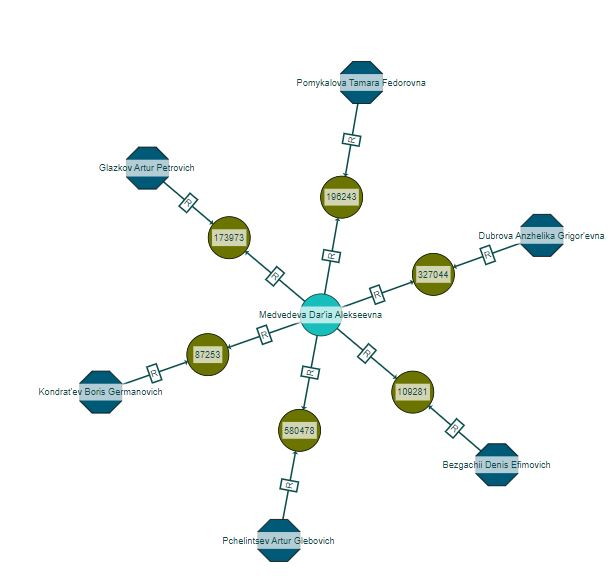

Это несложное сообщество с явным лидером и равноудаленными от него участниками

In [368]:
query_social_4_list = '''
MATCH (m:INTER{Name:"Medvedeva Dar'ia Alekseevna"})-[*]-(e:event)-[a]-(x)
WITH m AS lead, count(x) AS degree, collect(x) AS partisipant
RETURN lead, degree, partisipant
'''
participant_4 = session.run(query_social_4_list).data()
participant_4

[{'lead': {'Name': "Medvedeva Dar'ia Alekseevna"},
  'degree': 6,
  'partisipant': [{'Name': "Kondrat'ev Boris Germanovich"},
   {'Name': 'Pomykalova Tamara Fedorovna'},
   {'Name': 'Glazkov Artur Petrovich'},
   {'Name': 'Bezgachii Denis Efimovich'},
   {'Name': "Dubrova Anzhelika Grigor'evna"},
   {'Name': 'Pchelintsev Artur Glebovich'}]}]

In [369]:
query_social_5 = '''
MATCH  (m:INTER {Name:"Nedoveskov Vladimir Ivanovich"})-[b]->(e:event)-[a*]-(x) 
RETURN *
'''
session = driver.session()
graph = session.run(query_social_5).graph()
s5 = GraphWidget(graph = graph)
s5.set_node_styles_mapping(lambda index, node: styles.get(node['properties']['label'], {}))
s5.set_node_label_mapping(lambda index, node: node['properties']['Name'])
s5.show()

GraphWidget(layout=Layout(height='500px', width='100%'))

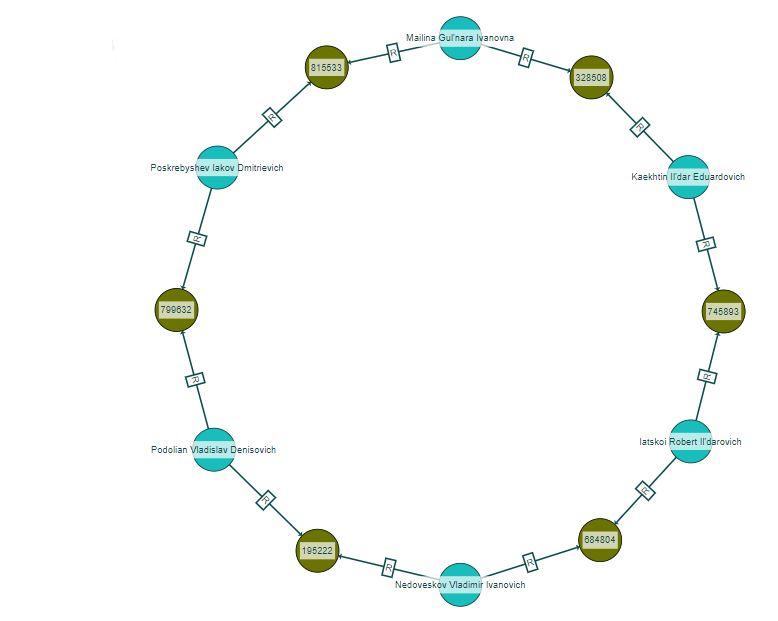

Круговое сообщество. В качестве характеристик имеет смысл перечислить участников и обозначить количество шагов от стартовой вершины до каждой. Алгоритм запроса обойдет граф с двух сторон и покажет число шагов до каждого участника с каждой стороны. Лидера нет. 

In [370]:
query_social_5_list = '''
MATCH p =  (m:INTER{Name: 'Nedoveskov Vladimir Ivanovich'})-[z*]-(x:person) 
RETURN  m AS start_member, collect(x) AS participant, length(p)/2 AS step
'''
participant_5 = session.run(query_social_5_list).data()
participant_5

[{'start_member': {'Name': 'Nedoveskov Vladimir Ivanovich'},
  'participant': [{'Name': "Iatskoi Robert Il'darovich"},
   {'Name': 'Podolian Vladislav Denisovich'}],
  'step': 1},
 {'start_member': {'Name': 'Nedoveskov Vladimir Ivanovich'},
  'participant': [{'Name': "Kaekhtin Il'dar Eduardovich"},
   {'Name': 'Poskrebyshev Iakov Dmitrievich'}],
  'step': 2},
 {'start_member': {'Name': 'Nedoveskov Vladimir Ivanovich'},
  'participant': [{'Name': "Mailina Gul'nara Ivanovna"},
   {'Name': "Mailina Gul'nara Ivanovna"}],
  'step': 3},
 {'start_member': {'Name': 'Nedoveskov Vladimir Ivanovich'},
  'participant': [{'Name': 'Poskrebyshev Iakov Dmitrievich'},
   {'Name': "Kaekhtin Il'dar Eduardovich"}],
  'step': 4},
 {'start_member': {'Name': 'Nedoveskov Vladimir Ivanovich'},
  'participant': [{'Name': 'Podolian Vladislav Denisovich'},
   {'Name': "Iatskoi Robert Il'darovich"}],
  'step': 5},
 {'start_member': {'Name': 'Nedoveskov Vladimir Ivanovich'},
  'participant': [{'Name': 'Nedoveskov V

In [371]:
query_social_6 = '''
MATCH  (m:INTER {Name:"Sholokhov Igor' Robertovich"})-[b]->(e:event)-[a*]-(x) 
RETURN *
'''
session = driver.session()
graph = session.run(query_social_6).graph()
s6 = GraphWidget(graph = graph)
s6.set_node_styles_mapping(lambda index, node: styles.get(node['properties']['label'], {}))
s6.set_node_label_mapping(lambda index, node: node['properties']['Name'])
s6.show()

GraphWidget(layout=Layout(height='500px', width='100%'))

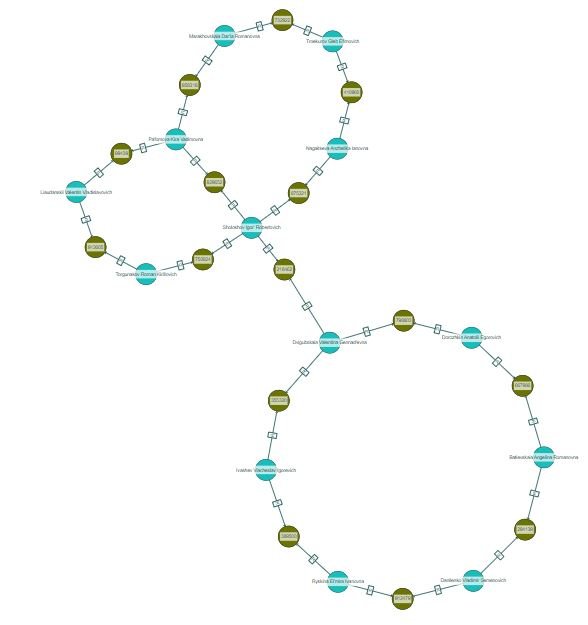

In [372]:
query_social_6_list ='''
MATCH p = (m:INTER {Name:"Sholokhov Igor' Robertovich"})-[a*]-(prt:person) 
RETURN min(length(p)/2) AS path, prt, count(a) AS con
'''
participant_6 = session.run(query_social_6_list).data()
participant_6

[{'path': 1, 'prt': {'Name': 'Nagaitseva Anzhelika Ianovna'}, 'con': 5},
 {'path': 2, 'prt': {'Name': 'Troekurov Gleb Efimovich'}, 'con': 5},
 {'path': 2, 'prt': {'Name': "Marakhovskaia Dar'ia Romanovna"}, 'con': 5},
 {'path': 1, 'prt': {'Name': 'Pafomova Kira Vadimovna'}, 'con': 9},
 {'path': 4, 'prt': {'Name': "Sholokhov Igor' Robertovich"}, 'con': 6},
 {'path': 1, 'prt': {'Name': "Dvigubskaia Valentina Gennad'evna"}, 'con': 21},
 {'path': 2, 'prt': {'Name': 'Ivashev Viacheslav Igorevich'}, 'con': 14},
 {'path': 3, 'prt': {'Name': "Ryskina El'mira Ivanovna"}, 'con': 14},
 {'path': 4, 'prt': {'Name': 'Danilenko Vladimir Semenovich'}, 'con': 14},
 {'path': 3, 'prt': {'Name': 'Batievskaia Angelina Romanovna'}, 'con': 14},
 {'path': 2, 'prt': {'Name': 'Dorozhkin Anatolii Egorovich'}, 'con': 14},
 {'path': 1, 'prt': {'Name': 'Torgunakov Roman Kirillovich'}, 'con': 5},
 {'path': 2, 'prt': {'Name': 'Liaudanskii Valentin Vladislavovich'}, 'con': 5}]

Самое непростое для анализа сообщество. За стартовую персону был взят "Sholokhov Igor' Robertovich". Посчитан минимальный путь обхода сообщества до каждого из участников path. Значение con характеризует количество возможных путей между стартовой персоной и каждым участником.

Таким образом удалось следующее: 
    - Загрузить датафрейм из файла CSV для подготовки к импорту в neo4j;
    - Импортировать данные в базу Neo4j с корректным учетом связей между сущностями;
    - Наладить связь из среды jupyter с базой Neo4j;
    - Составить несколько запросов, позволяющих провести поверхностный анализ сообществ и вывести результаты анализа: визуальные и количественные;
Не удалось: 
    - Применить алгоритмы автоматического поиска сообществ в базе по определенным признакам (кроме признака "по количеству связей");

# rest сервис на python к графовой БД в котором на вход поступает ФИО, на выходе graphml или json

Здесь реализован самый простой локальный сервис. После запуска следует открыть браузер по ссылке "http://127.0.0.1:7700/". Далее ввести русскими буквами ФИО интересующей персоны. В открытой странице браузера отобразится json со связанными вершинами. Остановка сервиса только принудительная. 

In [448]:
from flask import Flask, jsonify
import requests
from flask_restful import Resource, Api

app = Flask(__name__)
api = Api (app)

class GraphTest(Resource):
    def __init__(self):
        pass
    
    def get(self):
        person = unidecode.unidecode(str(input()))
        person_uni = '{Name:"' + person +'"}'
        query_social_rest = f'MATCH  (m:person {person_uni})-[b]->(e:event)-[a*]-(x) RETURN m AS main_person , e AS event, x AS person'
        session = driver.session()
        result = session.run(query_social_rest).data()
        return result

api.add_resource(GraphTest, '/')
if __name__ == "__main__":
    app.run(port = 7700 )

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:7700/ (Press CTRL+C to quit)


Гандыбина Любовь Александровна


127.0.0.1 - - [14/Mar/2023 06:49:53] "GET / HTTP/1.1" 200 -
